In [392]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.decomposition import PCA
from matplotlib.dates import DateFormatter
import yfinance as yf
import os
import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression


period: data period to download (either use period parameter or use start and end) Valid periods are:
“1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
interval: data interval (1m data is only for available for last 7 days, and data interval <1d for the last 60 days) Valid intervals are:
“1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”

In [393]:
def load_stock_data(ticker_symbol, start_date, end_date, interval, data_columns = None):
    # Check if CSV file exists
    csv_filename = f"{ticker_symbol}_{start_date}_{end_date}_{interval}.csv"
    if os.path.exists(csv_filename):
        # If CSV file exists, load data from CSV
        print("Loading data from CSV...")
        stock_data = pd.read_csv(csv_filename, index_col=None)

    else:
        # If CSV file does not exist, fetch data from Yahoo Finance
        print("Downloading data from Yahoo Finance...")
        stock_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval=interval)
        # Save data to CSV
        stock_data.to_csv(csv_filename)


    if data_columns != None:
        return stock_data[data_columns]

    return stock_data


def calculate_clustering_scores(X, labels):
    davies_bouldin = metrics.davies_bouldin_score(X, labels)
    silhouette_score = metrics.silhouette_score(X, labels)
    calinski_harabasz = metrics.calinski_harabasz_score(X, labels)

    print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
    print(f"Silhouette Score: {silhouette_score:.3f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

def plot_time_series(features, tiempo_columna, columna_visualizar, date_format="%Y-%m-%d %H:%M:%S", title='', figsize=(12, 6)):
    ts = features.copy()
    ts[tiempo_columna] = pd.to_datetime(ts[tiempo_columna], unit='ms')
    ts.set_index(tiempo_columna, inplace=True)

    plt.figure(figsize=figsize)
    plt.plot(ts[columna_visualizar], marker='.', linestyle='-')

    plt.title(title)
    plt.xlabel('Tiempo')
    plt.ylabel(columna_visualizar)

    date_form = DateFormatter(date_format)
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)

    plt.show()

def plot_isolation_forest(anomaly_labels, X, size):
    # Separa las instancias normales de las anomalías
    normal_instances = X[anomaly_labels == 1]
    anomaly_instances = X[anomaly_labels == -1]

    # Visualiza las instancias normales y las anomalías
    plt.scatter(normal_instances[:, 0], normal_instances[:, 1],
                c='blue', marker='o', s=size, label='Normal Instances')
    plt.scatter(anomaly_instances[:, 0], anomaly_instances[:, 1],
                c='red', marker='.', s=size, label='Anomaly Instances')

    plt.title("Isolation Forest Anomaly Detection", fontsize=14)
    plt.legend()
    plt.show()


def transform_data(stock_data, data_columns = None):
    hf = stock_data.copy()
   # Step 1: Convert 'Datetime' column if it exists
    if 'Datetime' in hf.columns:
        hf['Datetime'] = pd.to_datetime(hf['Datetime'], utc=True)
        hf['Datetime'] = hf['Datetime'].astype(int) // 10**9

    # Step 1: Convert 'Date' column if it exists
    if 'Date' in hf.columns:
        hf['Date'] = pd.to_datetime(hf['Date'])
        hf['Date'] = hf['Date'].astype(int) // 10**6

    features = hf
    features = features.dropna(axis=0)

    # Step 2
    scale_attrs = features
    robust_scaler = RobustScaler()
    X_train_scaled = robust_scaler.fit_transform(scale_attrs)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=data_columns or hf.columns)

    return X_train_scaled, robust_scaler



In [394]:
ticker_symbol = 'CL=F'
start_date = '2024-02-01'
end_date = '2024-02-28'
interval = "5m"

contamination=float(0.015)
max_samples=2048

data_columns = ["Datetime", "Open","Close", "Volume"]

# Define your pipeline
pipeline = Pipeline([
    ('load_data', FunctionTransformer(lambda x: load_stock_data(ticker_symbol, start_date, end_date, interval,data_columns), validate=False)),
    ('transform', FunctionTransformer(transform_data))
])

# Execute the pipeline
hf = pipeline.fit_transform(None)
X_train = hf[0]
scaler = hf[1]
print("Número de características:", len(X_train.columns))
print("Longitud del conjunto de datos:", len(X_train))
X_train.info()

Loading data from CSV...
Número de características: 4
Longitud del conjunto de datos: 4618
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4618 entries, 0 to 4617
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  4618 non-null   float64
 1   Open      4618 non-null   float64
 2   Close     4618 non-null   float64
 3   Volume    4618 non-null   float64
dtypes: float64(4)
memory usage: 144.4 KB


In [395]:
X_train.head(2)

,Datetime,Open,Close,Volume
0,-0.878160,-0.105557,-0.102779,-0.340986
1,-0.877913,-0.105557,-0.108333,-0.289116


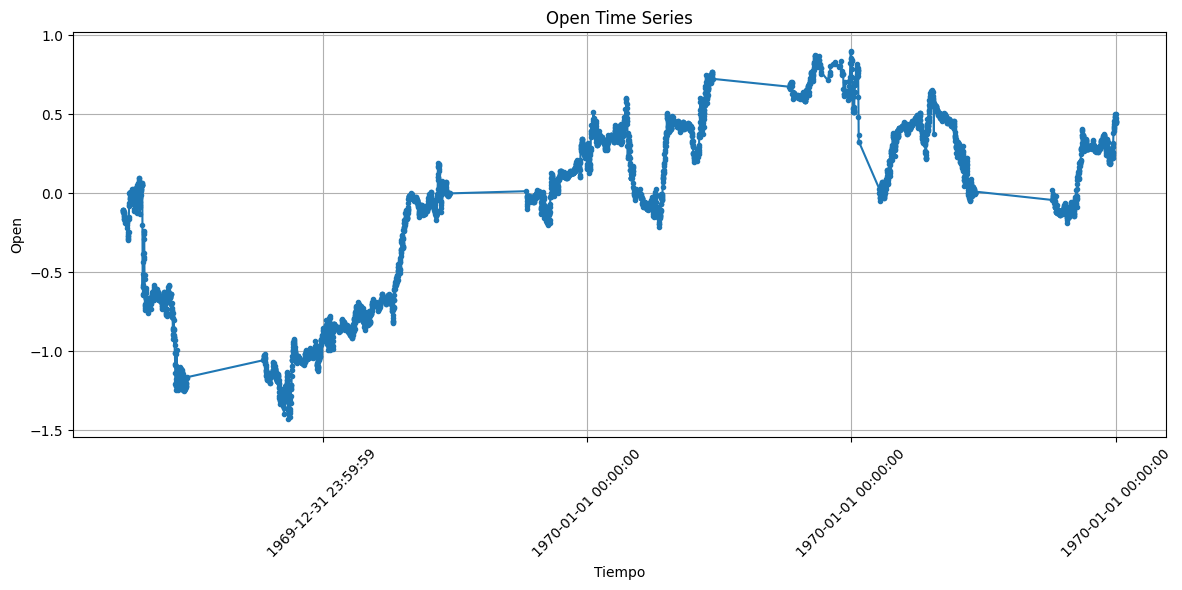

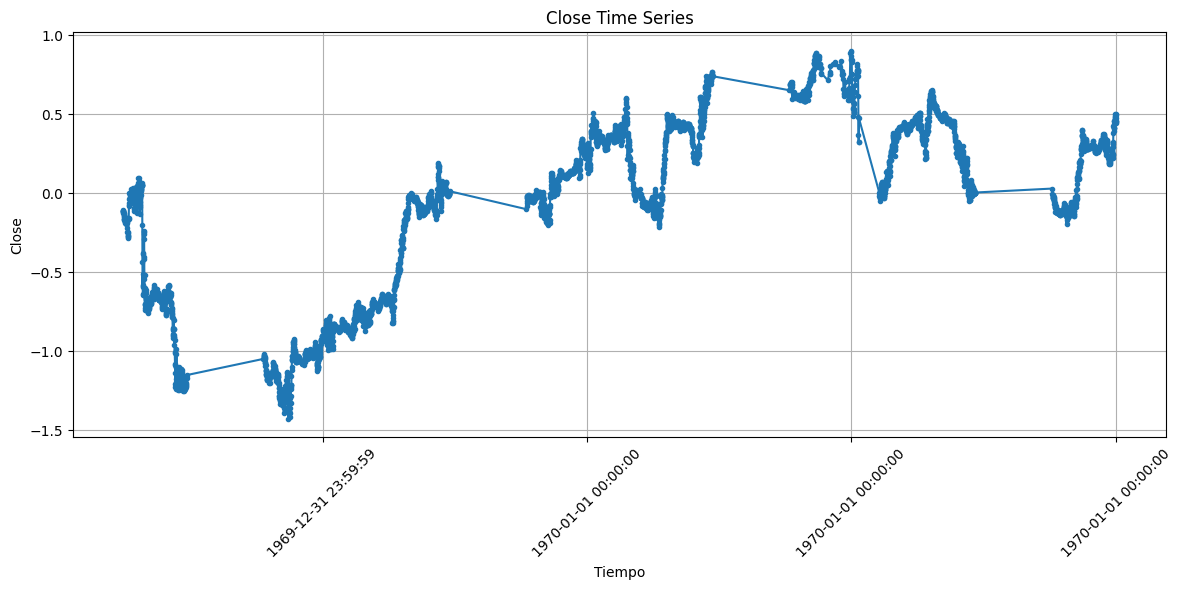

In [396]:
# Supongamos que 'tiempo' es la columna de tiempo y 'PA' es la columna que deseas visualizar.
plot_time_series(X_train, tiempo_columna='Datetime', columna_visualizar='Open', title='Open Time Series')
plot_time_series(X_train, tiempo_columna='Datetime', columna_visualizar='Close', title='Close Time Series')

In [397]:
ift_clf = IsolationForest(max_samples=max_samples, contamination=contamination)
ift_clf.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.015, max_samples=2048)

In [398]:
anomalies = ift_clf.predict(X_train)

X_train[anomalies==-1].value_counts()

Datetime   Open       Close      Volume   
-0.845604  -0.075001  -0.130556  7.470238     1
-0.409298  -0.741669  -0.761113  11.245748    1
 0.075102   0.541666   0.508332  5.057823     1
 0.016895   0.455556   0.355555  10.096088    1
 0.012209   0.513889   0.477776  5.415816     1
                                             ..
-0.764213  -1.188891  -1.250001  6.330782     1
-0.567394  -1.161112  -1.133334  6.070578     1
-0.565174  -1.311112  -1.425002  4.936224     1
-0.564928  -1.425002  -1.372223  3.259354     1
 0.998767   0.491666   0.502777  2.054422     1
Length: 70, dtype: int64

In [399]:
print("Total de anomalías identificadas:", len(X_train[anomalies==-1]))
print("Total precios normales:", len(X_train[anomalies==1]))

Total de anomalías identificadas: 70
Total precios normales: 4548


In [400]:
calculate_clustering_scores(X_train, anomalies)

Davies-Bouldin Index: 0.597
Silhouette Score: 0.769
Calinski-Harabasz Index: 1869.434


## Aplicando PCA para disminuir las dimensiones

In [401]:
pca = PCA(n_components=2)
df_reduced = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=df_reduced, columns=['C1', 'C2'])
pca_df.head(2)

,C1,C2
0,-0.798764,-0.563560
1,-0.746909,-0.560322


In [402]:
ift_clf_pca = IsolationForest(max_samples=max_samples, contamination=contamination)
ift_clf_pca.fit(pca_df)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.015, max_samples=2048)

In [403]:
pca_anomalies = ift_clf_pca.predict(pca_df)

In [404]:
print("Total de anomalías identificadas:", len(pca_df[pca_anomalies==-1]))
print("Total precios normales:", len(pca_df[pca_anomalies==1]))

Total de anomalías identificadas: 70
Total precios normales: 4548


In [405]:
calculate_clustering_scores(pca_df, pca_anomalies)

Davies-Bouldin Index: 0.466
Silhouette Score: 0.796
Calinski-Harabasz Index: 2514.866


In [406]:
# Calculamos la proporción de varianza que se ha preservado del conjunto original
pca.explained_variance_ratio_

array([0.69923721, 0.26384102])

#### El resultado anterior nos indica que el 73,20% de la varianza del conjunto de datos original se mantiene en el primer eje, y el 22.82% en el segundo eje. Esto quiere decir que aproximadamente 3.98% de la varianza se mantiene en el resto de ejes que no se han utilizado para construir el nuevo conjunto, por lo tanto, es razonable pensar que el resto de características del conjunto de datos no aportaban demasiada información.

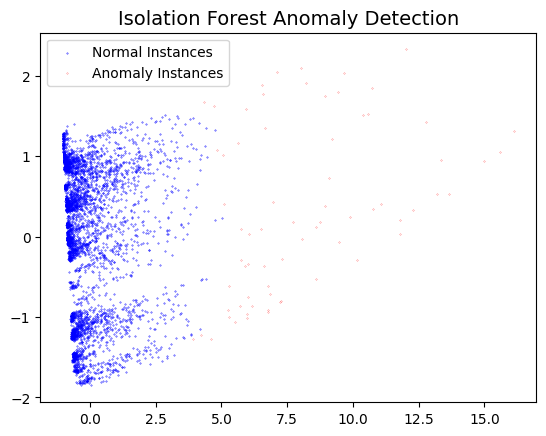

In [407]:
plot_isolation_forest(pca_anomalies, pca_df.values, size=0.1)

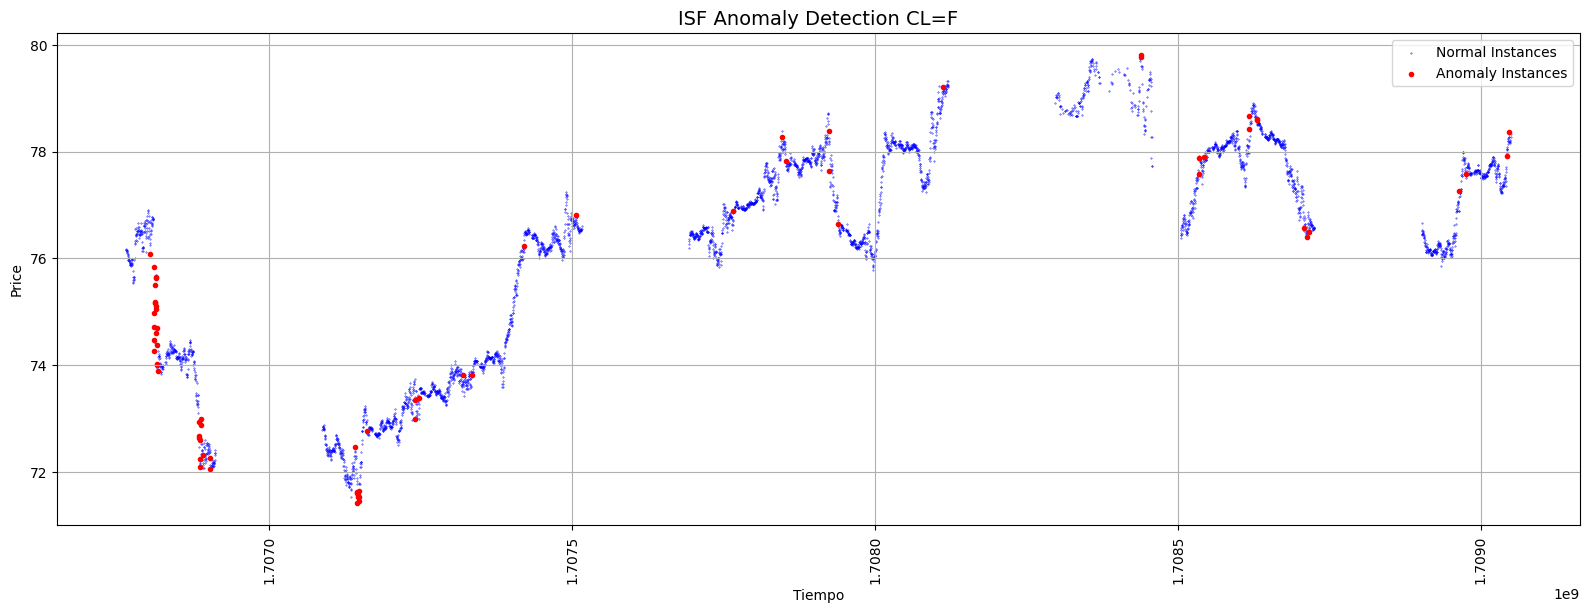

In [408]:
inversed_data = scaler.inverse_transform(X_train)
inversed_df = pd.DataFrame(inversed_data, columns=X_train.columns)
normal_instances = inversed_data[anomalies == 1]
anomaly_instances = inversed_data[anomalies == -1]

dates_normal = normal_instances[:, 0]
dates_anomaly = anomaly_instances[:, 0]

anomalies_plot = anomaly_instances[:, 2]
normal = normal_instances[:, 2]



plt.figure(figsize=(16,6))

# Visualiza las instancias normales y las anomalías

plt.scatter(dates_normal, normal,
            c='blue', marker='o',s=0.1,  label='Normal Instances')
plt.scatter(dates_anomaly, anomalies_plot,
            c='red', marker='.', label='Anomaly Instances')

plt.xlabel('Tiempo')
plt.ylabel('Price')

plt.xticks(rotation=90)
plt.tight_layout()


plt.title("ISF Anomaly Detection "+ticker_symbol, fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [409]:
nanomalies = 0
last_anomaly_date = [datetime.datetime.fromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S')for date in dates_anomaly[nanomalies:]]
last_anomaly_value = anomalies_plot[nanomalies:]

# Mayor valor
max_value = np.max(last_anomaly_value)

# Menor valor
min_value = np.min(last_anomaly_value)

# Promedio
mean_value = np.mean(last_anomaly_value)

# Volatilidad (desviación estándar)
volatility = np.std(last_anomaly_value)

print("El mayor valor es:", max_value)
print("El menor valor es:", min_value)
print("El promedio es:", mean_value)
print("La volatilidad es:", volatility)
print("Última anomalia:", last_anomaly_value[-1])

El mayor valor es: 79.80000305175781
El menor valor es: 71.41999816894531
El promedio es: 75.0229995727539
La volatilidad es: 2.448805078403791
Última anomalia: 78.36000061035156


In [410]:
data = {
    'Datetime': last_anomaly_date,
    'Price': last_anomaly_value
}

df = pd.DataFrame(data)

# Define your pipeline
pipeline = Pipeline([
    ('transform', FunctionTransformer(lambda x: transform_data(df)))
])

# Execute the pipeline
hf_regression = pipeline.fit_transform(None)
X_train_regression = hf_regression[0]
scaler_regression = hf_regression[1]
X_train_regression.head(2)

,Datetime,Price
0,-0.306528,0.280982
1,-0.301440,0.223872


Parámetro theta 0: -0.1367137369475417
Parámetro theta 1: [0.62130137]


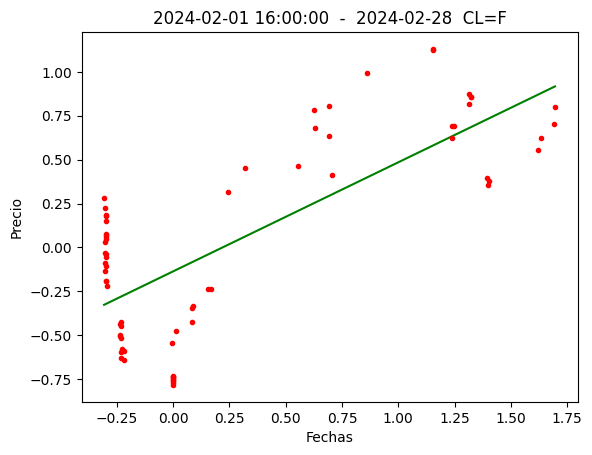

In [411]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_regression["Datetime"].values.reshape(-1, 1), X_train_regression["Price"].values)
#
print("Parámetro theta 0:",lin_reg.intercept_)
print("Parámetro theta 1:",lin_reg.coef_)

# Predicción para el valor mínimo y máximo del conjunto de datos de entrenamiento
X_min_max = np.array([[X_train_regression["Datetime"].min()], [X_train_regression["Datetime"].max()]])


y_train_pred = lin_reg.predict(X_min_max)

# Representación gráfica de la función hipótesis generada
plt.plot(X_min_max, y_train_pred, "g-")
plt.plot(X_train_regression["Datetime"],X_train_regression["Price"], "r.")
plt.title(last_anomaly_date[0] + "  -  " + end_date  + "  " + ticker_symbol)
plt.xlabel("Fechas")
plt.ylabel("Precio")
plt.show()

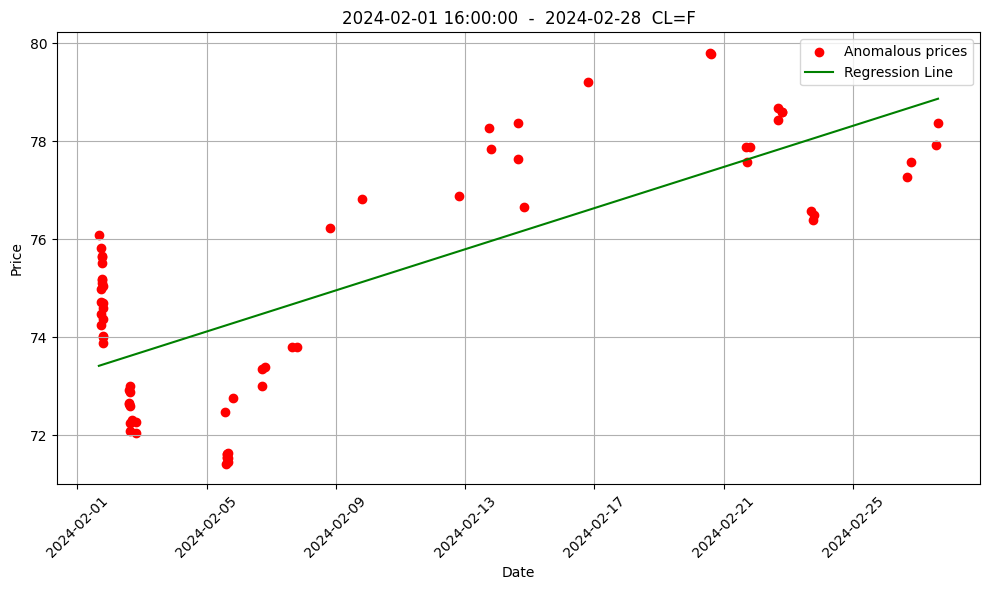

In [412]:
y_train_pred_inverse = scaler_regression.inverse_transform(np.column_stack((X_min_max.flatten(), y_train_pred)))
# Extracting the reversed scaled prediction for "Price" only
y_train_pred_price_only = y_train_pred_inverse[:, 1]

# Convert the regression feature (Datetime) back to its original form
X_train_dates_original = (scaler_regression.inverse_transform(X_train_regression)[:, 0]).astype('datetime64[s]')
min_date = min(X_train_dates_original)
max_date = max(X_train_dates_original)

linear_dates = [min_date, max_date]
linear_regression_predictions = y_train_pred_price_only

plt.figure(figsize=(10, 6))
plt.scatter(X_train_dates_original, df['Price'], color="red", label="Anomalous prices")
plt.plot(linear_dates, linear_regression_predictions, "g-", label="Regression Line")

plt.title(last_anomaly_date[0] + "  -  " + end_date  + "  " + ticker_symbol)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.grid(True)
plt.show()